## JIRA - Issues Resolution Date Prediction

### Ahmad Diab
### May 2023

In [377]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [378]:
# Data manipulation and computation libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# Machine Learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Boosting library
import xgboost as xgb

# File handling library
import h5py

# The preprocessing function that I created
from preprocessing import preprocess_data



In [379]:
# Read the tracking issue CSV file located in data folder
df_avro_issues = pd.read_csv('../data/avro-issues.csv')

# Read the transition issue CSV file located in data folder
df_avro_transitions = pd.read_csv('../data/avro-transitions.csv')

## AVRO TRANSITIONS

In [380]:
df_avro_transitions.head()

,status,updated,from_status,reporter,when,days_in_from_status,who,to_status,assignee,key,...,project,created,transition,resolutiondate,comment_count,priority,vote_count,issue_type,watch_count,resolution
0,In Progress,2018-04-21T15:44:36.749+0000,NaN,rlenferink,2018-04-17T21:53:05.730+0000,NaN,rlenferink,Open,rlenferink,AVRO-2171,...,AVRO,2018-04-17T21:53:05.730+0000,Non-existent to Open,NaN,1,Major,0,Improvement,1,NaN
1,In Progress,2018-04-21T15:44:36.749+0000,Open,rlenferink,2018-04-18T01:33:49.088+0000,0.153280,busbey,Patch Available,rlenferink,AVRO-2171,...,AVRO,2018-04-17T21:53:05.730+0000,Open to Patch Available,NaN,1,Major,0,Improvement,1,NaN
2,In Progress,2018-04-21T15:44:36.749+0000,Patch Available,rlenferink,2018-04-21T15:44:36.753+0000,3.590829,busbey,In Progress,rlenferink,AVRO-2171,...,AVRO,2018-04-17T21:53:05.730+0000,Patch Available to In Progress,NaN,1,Major,0,Improvement,1,NaN
3,In Progress,2018-04-21T15:42:40.935+0000,NaN,rlenferink,2018-04-17T21:47:11.197+0000,NaN,rlenferink,Open,rlenferink,AVRO-2170,...,AVRO,2018-04-17T21:47:11.197+0000,Non-existent to Open,NaN,1,Minor,0,Improvement,2,NaN
4,In Progress,2018-04-21T15:42:40.935+0000,Open,rlenferink,2018-04-18T01:33:19.205+0000,0.157037,busbey,Patch Available,rlenferink,AVRO-2170,...,AVRO,2018-04-17T21:47:11.197+0000,Open to Patch Available,NaN,1,Minor,0,Improvement,2,NaN


In [381]:
df_avro_transitions.columns

Index(['status', 'updated', 'from_status', 'reporter', 'when',
       'days_in_from_status', 'who', 'to_status', 'assignee', 'key',
       'description_length', 'summary_length', 'days_in_current_status',
       'days_since_open', 'project', 'created', 'transition', 'resolutiondate',
       'comment_count', 'priority', 'vote_count', 'issue_type', 'watch_count',
       'resolution'],
      dtype='object')

In [382]:
# Create a new DataFrame from a subset of df_avro_transitions, selecting only the needed columns.
# The .copy() at the end ensures that df_transitions is a completely separate DataFrame, not a view on the original df_avro_transition.
df_transitions = df_avro_transitions[['from_status', 'to_status', 'transition', 'days_since_open', 'key']].copy()

df_transitions.head()


,from_status,to_status,transition,days_since_open,key
0,NaN,Open,Non-existent to Open,NaN,AVRO-2171
1,Open,Patch Available,Open to Patch Available,0.153280,AVRO-2171
2,Patch Available,In Progress,Patch Available to In Progress,3.744109,AVRO-2171
3,NaN,Open,Non-existent to Open,NaN,AVRO-2170
4,Open,Patch Available,Open to Patch Available,0.157037,AVRO-2170


In [383]:
df_transitions.shape

(6260, 5)

In [384]:
# Remove the Non-existent to Open transition because the days_since_open is calculated since created/open
df_transitions = df_transitions[~(df_transitions['transition'].str.contains('Non-existent to Open') | df_transitions['transition'].str.contains('Resolved to Closed'))]


In [385]:
df_transitions.head()

,from_status,to_status,transition,days_since_open,key
1,Open,Patch Available,Open to Patch Available,0.153280,AVRO-2171
2,Patch Available,In Progress,Patch Available to In Progress,3.744109,AVRO-2171
4,Open,Patch Available,Open to Patch Available,0.157037,AVRO-2170
5,Patch Available,In Progress,Patch Available to In Progress,3.746872,AVRO-2170
7,Open,Resolved,Open to Resolved,17.701042,AVRO-2169


In [386]:
df_transitions.shape

(2858, 5)

## AVRO ISSUES

In [387]:
df_avro_issues.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,In Progress,Major,2018-04-21T15:44:36.749+0000,Improvement,rlenferink,2018-04-17T21:53:05.730+0000,NaN,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599
1,In Progress,Minor,2018-04-21T15:42:40.935+0000,Improvement,rlenferink,2018-04-17T21:47:11.197+0000,NaN,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939
2,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06T13:45:28.721+0000,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288
3,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05T13:21:01.183+0000,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04T16:39:43.364+0000,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785


In [388]:
df_avro_issues.shape

(2166, 17)

In [389]:
df_avro_issues.columns

Index(['status', 'priority', 'updated', 'issue_type', 'reporter', 'created',
       'resolutiondate', 'vote_count', 'project', 'assignee', 'comment_count',
       'key', 'description_length', 'summary_length', 'watch_count',
       'resolution', 'days_in_current_status'],
      dtype='object')

In [390]:
df_avro_issues.dtypes

status                     object
priority                   object
updated                    object
issue_type                 object
reporter                   object
created                    object
resolutiondate             object
vote_count                  int64
project                    object
assignee                   object
comment_count               int64
key                        object
description_length        float64
summary_length              int64
watch_count                 int64
resolution                 object
days_in_current_status    float64
dtype: object

### Data proeprocessing function exists in the preprocessing.py file
#### It takes the raw data and return a preprocessed and encoded data for modeling

In [391]:
# Create a new DataFrame from a subset of df_avro_issues, selecting only the needed columns.
# The .copy() at the end ensures that df_issues is a completely separate DataFrame, not a view on the original df_avro_issues.
df_issues = df_avro_issues[['key', 'status', 'priority', 'issue_type', 'created', 'resolutiondate', 'updated', 'description_length', 'summary_length', 'watch_count', 'comment_count']].copy()

# Define the list of columns that contain datetime data.
datetime_columns = ['created', 'updated', 'resolutiondate']

# Loop over the datetime columns.
for column in datetime_columns:
    # Convert the column in df_issues to datetime format. 
    # The .loc[:, column] part ensures that the operation is done in-place on df_issues.
    df_issues.loc[:, column] = pd.to_datetime(df_issues.loc[:, column])
    
    # Format the datetime objects as strings in the format 'YYYY-MM-DD HH:MM:SS'.
    df_issues.loc[:, column] = df_issues.loc[:, column].dt.strftime('%Y-%m-%d %H:%M:%S')

# Display the first 5 rows of df_issues to check the results.
df_issues.head()


,key,status,priority,issue_type,created,resolutiondate,updated,description_length,summary_length,watch_count,comment_count
0,AVRO-2171,In Progress,Major,Improvement,2018-04-17 21:53:05,NaT,2018-04-21 15:44:36,233.0,43,1,1
1,AVRO-2170,In Progress,Minor,Improvement,2018-04-17 21:47:11,NaT,2018-04-21 15:42:40,528.0,68,2,1
2,AVRO-2169,Resolved,Major,Improvement,2018-04-06 13:45:28,2018-04-24 06:34:58,2018-04-24 06:34:58,1062.0,75,1,0
3,AVRO-2168,Resolved,Major,Bug,2018-04-05 13:21:01,2018-04-24 06:34:37,2018-04-24 06:34:37,272.0,64,1,1
4,AVRO-2167,Resolved,Major,Bug,2018-04-04 16:39:43,2018-04-24 06:34:15,2018-04-24 06:34:15,674.0,53,1,0


In [392]:
# Convert object columns to datetime
df_issues['created'] = pd.to_datetime(df_issues['created'])
df_issues['updated'] = pd.to_datetime(df_issues['updated'])
df_issues['resolutiondate'] = pd.to_datetime(df_issues['resolutiondate'])

### Feature Engineering 

In [393]:
# Calculate the time difference in seconds
time_difference = (df_issues['resolutiondate'] - df_issues['created']).dt.total_seconds()

# Convert the time difference to days with fraction
df_issues['days_since_created'] = (time_difference / (24 * 60 * 60)).round()

In [394]:
df_issues.head()

,key,status,priority,issue_type,created,resolutiondate,updated,description_length,summary_length,watch_count,comment_count,days_since_created
0,AVRO-2171,In Progress,Major,Improvement,2018-04-17 21:53:05,NaT,2018-04-21 15:44:36,233.0,43,1,1,NaN
1,AVRO-2170,In Progress,Minor,Improvement,2018-04-17 21:47:11,NaT,2018-04-21 15:42:40,528.0,68,2,1,NaN
2,AVRO-2169,Resolved,Major,Improvement,2018-04-06 13:45:28,2018-04-24 06:34:58,2018-04-24 06:34:58,1062.0,75,1,0,18.0
3,AVRO-2168,Resolved,Major,Bug,2018-04-05 13:21:01,2018-04-24 06:34:37,2018-04-24 06:34:37,272.0,64,1,1,19.0
4,AVRO-2167,Resolved,Major,Bug,2018-04-04 16:39:43,2018-04-24 06:34:15,2018-04-24 06:34:15,674.0,53,1,0,20.0


In [395]:
# Extract day name, weekend/weekday, and month name

# Extract day name
df_issues['created_day_name'] = df_issues['created'].dt.day_name()

# Extract whether the day is a weekend or weekday
df_issues['created_is_weekend'] = df_issues['created'].dt.weekday >= 5  # This will return True if the day is Saturday or Sunday, and False otherwise

# Extract month name
df_issues['created_month_name'] = df_issues['created'].dt.month_name()


In [396]:
df_issues.head()

,key,status,priority,issue_type,created,resolutiondate,updated,description_length,summary_length,watch_count,comment_count,days_since_created,created_day_name,created_is_weekend,created_month_name
0,AVRO-2171,In Progress,Major,Improvement,2018-04-17 21:53:05,NaT,2018-04-21 15:44:36,233.0,43,1,1,NaN,Tuesday,False,April
1,AVRO-2170,In Progress,Minor,Improvement,2018-04-17 21:47:11,NaT,2018-04-21 15:42:40,528.0,68,2,1,NaN,Tuesday,False,April
2,AVRO-2169,Resolved,Major,Improvement,2018-04-06 13:45:28,2018-04-24 06:34:58,2018-04-24 06:34:58,1062.0,75,1,0,18.0,Friday,False,April
3,AVRO-2168,Resolved,Major,Bug,2018-04-05 13:21:01,2018-04-24 06:34:37,2018-04-24 06:34:37,272.0,64,1,1,19.0,Thursday,False,April
4,AVRO-2167,Resolved,Major,Bug,2018-04-04 16:39:43,2018-04-24 06:34:15,2018-04-24 06:34:15,674.0,53,1,0,20.0,Wednesday,False,April


In [397]:
df_issues.dtypes

key                           object
status                        object
priority                      object
issue_type                    object
created               datetime64[ns]
resolutiondate        datetime64[ns]
updated               datetime64[ns]
description_length           float64
summary_length                 int64
watch_count                    int64
comment_count                  int64
days_since_created           float64
created_day_name              object
created_is_weekend              bool
created_month_name            object
dtype: object

### Summary Staistics

In [398]:
df_issues.isnull().mean().round(4)*100

key                    0.00
status                 0.00
priority               0.00
issue_type             0.00
created                0.00
resolutiondate        30.06
updated                0.00
description_length     4.29
summary_length         0.00
watch_count            0.00
comment_count          0.00
days_since_created    30.06
created_day_name       0.00
created_is_weekend     0.00
created_month_name     0.00
dtype: float64

In [399]:
# Check the percentage of NaNs exist in our dataset
nan_percentage = df_issues.isnull().mean().round(4)*100

In [400]:
# Create an interactive bar chart using Plotly
fig = px.bar(nan_percentage, x=nan_percentage.index, y=nan_percentage.values,
             labels={'x': 'Features', 'y': 'Percentage of NaNs'},
             title='Percentage of NaNs in Each Feature', color = nan_percentage.index)
fig.update_layout(showlegend=False)  # Remove the legend

fig.show()

In [401]:
df_issues[df_issues['status'] == 'Resolved'].describe()[['days_since_created']]

,days_since_created
count,279.000000
mean,196.874552
std,424.477421
min,0.000000
25%,4.500000
50%,22.000000
75%,153.500000
max,2222.000000


In [402]:
df_issues[df_issues['status'] == 'Closed'].describe()[['days_since_created']]

,days_since_created
count,1236.000000
mean,57.186893
std,160.424936
min,0.000000
25%,1.000000
50%,7.000000
75%,35.000000
max,2102.000000


In [403]:
df_issues.describe()

,description_length,summary_length,watch_count,comment_count,days_since_created
count,2073.000000,2166.000000,2166.000000,2166.000000,1515.000000
mean,697.887120,52.825946,2.337950,5.716066,82.911551
std,1054.484083,20.968528,3.135038,7.595926,238.771573
min,15.000000,8.000000,0.000000,0.000000,0.000000
25%,182.000000,38.000000,1.000000,2.000000,2.000000
50%,353.000000,51.000000,2.000000,4.000000,9.000000
75%,788.000000,65.000000,3.000000,7.000000,47.000000
max,17439.000000,186.000000,74.000000,97.000000,2222.000000


In [404]:
# Get the top values and their frequencies, count and unique values for all columns
count_values = df_issues.apply(lambda x: x.count())
unique_values = df_issues.apply(lambda x: x.nunique())
top_values = df_issues.apply(lambda x: x.value_counts().index[0])
freq_values = df_issues.apply(lambda x: x.value_counts().max())

# Create a summary DataFrame with top values, frequencies, count, and unique values
summary_df = pd.DataFrame({'count': count_values, 'unique': unique_values, 'top': top_values, 'freq': freq_values})
summary_df

,count,unique,top,freq
key,2166,2166,AVRO-48,1
status,2166,6,Closed,1236
priority,2166,5,Major,1537
issue_type,2166,7,Bug,1012
created,2166,2166,2012-12-07 21:21:39,1
resolutiondate,1515,1515,2009-05-26 18:06:47,1
updated,2166,1263,2010-03-01 17:09:21,14
description_length,2073,1062,271,9
summary_length,2166,120,55,53
watch_count,2166,24,1,541


## EDA

### EDA Avro issues dataset

In [405]:
# Compute the value counts for 'status' column
value_counts = df_issues['status'].value_counts()

# Create a bar plot using plotly
fig = px.bar(value_counts, orientation='v', title='Number of Issue Status', color=value_counts.index)

# Add x-label
fig.update_xaxes(title_text='Issue Status')

# Show the plot
fig.show()


In [406]:
# Replace Closed issues by Resolved because the resolutiondate for Closed issues is the date when it's resolved
df_issues['status'] = df_issues['status'].replace('Closed', 'Resolved')

In [407]:
# Compute the value counts for 'status' column after replacing Closed by Resolved
value_counts = df_issues['status'].value_counts()

# Create a bar plot using plotly
fig = px.bar(value_counts, orientation='v', title='Number of Issue Status', color=value_counts.index)

# Show the plot
fig.show()


In [408]:
# Check the occurrence of each issue type in the dataset

# Group the dataframe by 'issue_type' and calculate the count of occurrences
grouped = df_issues['issue_type'].value_counts().reset_index()

# Rename the columns for clarity
grouped.columns = ['issue_type', 'count']

# Create an interactive bar plot using Plotly Express
fig = px.bar(grouped, x='issue_type', y='count', title='Number of Issues per Issue Type', color='issue_type')
fig.update_layout(xaxis_title='Issue Type', yaxis_title='Count')

# Show the plot
fig.show()

In [409]:
# Analyzing the Creation Days of Issues

# Compute the value counts for 'created_day_name' column
value_counts = df_issues['created_day_name'].value_counts()

# Create a bar plot using plotly
fig = px.bar(value_counts, orientation='v', title='Number of issues created per weekday', color=value_counts.values, color_continuous_scale='Temps')

# Show the plot
fig.show()


In [410]:
# Analyzing the Creation Months of Issues

# Compute the value counts for 'created_month_name' column
value_counts = df_issues['created_month_name'].value_counts()

# Create a bar plot using plotly
fig = px.bar(value_counts, orientation='v', title='Number of issues created per month', color=value_counts.values, color_continuous_scale='Temps')

# Show the plot
fig.show()


In [411]:
# Analyzing the Proportion of Issues Created on Weekends versus Weekdays

# Calculate the count of issues created on weekends and weekdays
weekend_count = df_issues['created_is_weekend'].sum()
weekday_count = len(df_issues) - weekend_count

# Create a dataframe for the bar chart
data = {'Type': ['Weekends', 'Weekdays'], 'Count': [weekend_count, weekday_count]}
df_bar = pd.DataFrame(data)

# Create an interactive horizontal bar chart to display the proportion of issues created on weekends versus weekdays
fig = px.bar(df_bar, x='Count', y='Type', orientation='h', title='Proportion of Issues Created on Weekends vs. Weekdays')

# Customize the plot
fig.update_layout(xaxis_title='Count', yaxis_title='Type')

# Show the plot
fig.show()


In [412]:
# Checking Outliers in the "days_since_created" Column

# Create an interactive boxplot using Plotly Express
fig = px.box(df_issues, y='days_since_created', title='Days since created Boxplot')

# Show the plot
fig.show()


In [413]:
# Checking Outliers in the "description_length" Column

# Create an interactive boxplot using Plotly Express
fig = px.box(df_issues, y='description_length', title='Description Length Boxplot')

# Show the plot
fig.show()

In [414]:
# Exploring Relationship between Description Length, Priority, and Issue Type

# Create an interactive scatter plot matrix using Plotly Express
fig = px.scatter_matrix(df_issues, dimensions=['description_length', 'priority', 'issue_type'],
                        color='issue_type', title='Correlation: Description Length, Priority, and Issue Type')

# Show the plot
fig.show()


## Since the description length shown in the above boxplot shows that there are too high lengths like 17K
## (most probably 17K characters, which is equal to 3487 words that make around 14 A4 pages if 1 page contains 250 words)
## I decided to check the below scatter matrix to check the relationship between these high lengths with the issue_type and priority

## And from it I can see that these high lengths are related to Major issues and are related to Bugs or New Features issue types
## This might be because the issue reporter pasted a long bug error description from somewhere


In [415]:
# Exploring Relationship between Days Since Created, Watch Count, and/in terms of Priority

# Create an interactive scatter plot to visualize the relationship between 'days_since_created' and 'watch_count' with colored markers based on 'status'
fig = px.scatter(df_issues, x='days_since_created', y='watch_count', title='Days Since Created vs. Watch Count', color = 'priority')

# Customize the plot
fig.update_layout(xaxis_title='Days Since Created', yaxis_title='Watch Count')

# Show the plot
fig.show()


In [416]:
# Exploring Relationship between Days Since Created, Comment Count, and/in terms of Priority

# Create an interactive bubble plot to visualize the relationship between 'days_since_created' and 'comment_count' with colored markers based on 'status'
fig = px.scatter(df_issues, x='days_since_created', y='comment_count', size='comment_count', title='Days Since Created vs. Comment Count', color = 'priority')

# Customize the plot
fig.update_layout(xaxis_title='Days Since Created', yaxis_title='Comment Count')

# Show the plot
fig.show()


In [417]:
# Check the bottleneck in transition durations

# Create the DataFrame
result_transition = pd.DataFrame(df_avro_transitions.groupby('transition')['days_in_from_status'].mean())

# Sort the DataFrame
result_transition = result_transition.sort_values(by='days_in_from_status', ascending=False)

result_transition

,days_in_from_status
transition,
Open to Resolved,81.289481
Open to In Progress,79.636178
Patch Available to In Progress,73.635255
Resolved to Closed,64.637620
Reopened to Resolved,56.101577
Resolved to Reopened,48.946111
Open to Patch Available,48.144239
Patch Available to Resolved,30.395703
Patch Available to Open,27.275544


In [418]:
# Analyzing Transition Durations to Check the Bottleneck

# Resetting index for better handling in plotly
result_transition.reset_index(inplace=True)

fig = go.Figure(data=[go.Bar(
    x=result_transition['transition'],
    y=result_transition['days_in_from_status'],
    marker_color=result_transition.index
)])

fig.update_layout(title_text='Total Days in Each Status', xaxis_title='Transition', yaxis_title='Total Days in Status')

fig.show()


## Encoding Categorical Values

In [419]:
print(df_issues['status'].unique())
print(df_issues['priority'].unique())
print(df_issues['issue_type'].unique())
print(df_issues['created_day_name'].unique())
print(df_issues['created_month_name'].unique())
print(df_issues['created_is_weekend'].unique())

['In Progress' 'Resolved' 'Patch Available' 'Open' 'Reopened']
['Major' 'Minor' 'Critical' 'Trivial' 'Blocker']
['Improvement' 'Bug' 'Task' 'New Feature' 'Wish' 'Test' 'Sub-task']
['Tuesday' 'Friday' 'Thursday' 'Wednesday' 'Sunday' 'Saturday' 'Monday']
['April' 'March' 'February' 'January' 'December' 'November' 'October'
 'September' 'August' 'July' 'June' 'May']
[False  True]


In [420]:
df_issues

,key,status,priority,issue_type,created,resolutiondate,updated,description_length,summary_length,watch_count,comment_count,days_since_created,created_day_name,created_is_weekend,created_month_name
0,AVRO-2171,In Progress,Major,Improvement,2018-04-17 21:53:05,NaT,2018-04-21 15:44:36,233.0,43,1,1,NaN,Tuesday,False,April
1,AVRO-2170,In Progress,Minor,Improvement,2018-04-17 21:47:11,NaT,2018-04-21 15:42:40,528.0,68,2,1,NaN,Tuesday,False,April
2,AVRO-2169,Resolved,Major,Improvement,2018-04-06 13:45:28,2018-04-24 06:34:58,2018-04-24 06:34:58,1062.0,75,1,0,18.0,Friday,False,April
3,AVRO-2168,Resolved,Major,Bug,2018-04-05 13:21:01,2018-04-24 06:34:37,2018-04-24 06:34:37,272.0,64,1,1,19.0,Thursday,False,April
4,AVRO-2167,Resolved,Major,Bug,2018-04-04 16:39:43,2018-04-24 06:34:15,2018-04-24 06:34:15,674.0,53,1,0,20.0,Wednesday,False,April
5,AVRO-2166,Resolved,Major,Bug,2018-04-04 16:29:37,2018-04-24 06:32:37,2018-04-24 06:32:37,1043.0,39,2,1,20.0,Wednesday,False,April
6,AVRO-2165,Patch Available,Minor,Improvement,2018-04-01 13:08:48,NaT,2018-04-01 13:19:20,307.0,57,1,1,NaN,Sunday,True,April
7,AVRO-2164,Open,Major,Improvement,2018-03-23 13:13:13,NaT,2018-03-23 17:16:08,1101.0,32,4,6,NaN,Friday,False,March
8,AVRO-2163,Open,Major,Task,2018-03-22 18:10:17,NaT,2018-03-23 08:14:38,83.0,13,1,0,NaN,Thursday,False,March
9,AVRO-2162,Open,Major,Improvement,2018-03-22 07:38:21,NaT,2018-03-30 09:30:51,430.0,45,3,11,NaN,Thursday,False,March


In [421]:
# Create a Copy of df_issues to Preserve the Original Data
encoded_df_issues = df_issues.copy()

In [422]:
# Converting Ordinal Categories into Categorical Codes

# Define the order
status_order = ['Open', 'Patch Available', 'In Progress', 'Resolved', 'Reopened', 'Closed']
# Convert the column to an ordered categorical type
encoded_df_issues['status'] = pd.Categorical(encoded_df_issues['status'], categories=status_order, ordered=True)
# Convert the ordered categorical data to codes. Add +1 so the codes start from 1 instead of 0
encoded_df_issues['status'] = encoded_df_issues['status'].cat.codes + 1


# Define the order
priority_order = ['Trivial', 'Minor', 'Major', 'Critical', 'Blocker']
# Convert the column to an ordered categorical type
encoded_df_issues['priority'] = pd.Categorical(encoded_df_issues['priority'], categories=priority_order, ordered=True)
# Convert the ordered categorical data to codes. Add +1 so the codes start from 1 instead of 0
encoded_df_issues['priority'] = encoded_df_issues['priority'].cat.codes + 1


# Define the order
created_day_name_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Convert the column to an ordered categorical type
encoded_df_issues['created_day_name'] = pd.Categorical(encoded_df_issues['created_day_name'], categories=created_day_name_order, ordered=True)
# Convert the ordered categorical data to codes. Add +1 so the codes start from 1 instead of 0
encoded_df_issues['created_day_name'] = encoded_df_issues['created_day_name'].cat.codes + 1


# Define the order
created_month_name_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
                  'October', 'November', 'December']
# Convert the column to an ordered categorical type
encoded_df_issues['created_month_name'] = pd.Categorical(encoded_df_issues['created_month_name'], categories=created_month_name_order, ordered=True)
# Convert the ordered categorical data to codes. Add +1 so the codes start from 1 instead of 0
encoded_df_issues['created_month_name'] = encoded_df_issues['created_month_name'].cat.codes + 1


In [423]:
# One-hot encoding for the nominal category
encoder = LabelEncoder()
encoded_df_issues['issue_type'] = encoder.fit_transform(encoded_df_issues['issue_type'])

In [424]:
# Mapping Weekday Indicator to Numerical Values
encoded_df_issues['created_is_weekend'] = encoded_df_issues['created_is_weekend'].map({True: 1, False: 0})

In [425]:
# # Drop the updated column
# encoded_df_issues.drop(['updated'], axis=1, inplace=True)

In [426]:
encoded_df_issues

,key,status,priority,issue_type,created,resolutiondate,updated,description_length,summary_length,watch_count,comment_count,days_since_created,created_day_name,created_is_weekend,created_month_name
0,AVRO-2171,3,3,1,2018-04-17 21:53:05,NaT,2018-04-21 15:44:36,233.0,43,1,1,NaN,2,0,4
1,AVRO-2170,3,2,1,2018-04-17 21:47:11,NaT,2018-04-21 15:42:40,528.0,68,2,1,NaN,2,0,4
2,AVRO-2169,4,3,1,2018-04-06 13:45:28,2018-04-24 06:34:58,2018-04-24 06:34:58,1062.0,75,1,0,18.0,5,0,4
3,AVRO-2168,4,3,0,2018-04-05 13:21:01,2018-04-24 06:34:37,2018-04-24 06:34:37,272.0,64,1,1,19.0,4,0,4
4,AVRO-2167,4,3,0,2018-04-04 16:39:43,2018-04-24 06:34:15,2018-04-24 06:34:15,674.0,53,1,0,20.0,3,0,4
5,AVRO-2166,4,3,0,2018-04-04 16:29:37,2018-04-24 06:32:37,2018-04-24 06:32:37,1043.0,39,2,1,20.0,3,0,4
6,AVRO-2165,2,2,1,2018-04-01 13:08:48,NaT,2018-04-01 13:19:20,307.0,57,1,1,NaN,7,1,4
7,AVRO-2164,1,3,1,2018-03-23 13:13:13,NaT,2018-03-23 17:16:08,1101.0,32,4,6,NaN,5,0,3
8,AVRO-2163,1,3,4,2018-03-22 18:10:17,NaT,2018-03-23 08:14:38,83.0,13,1,0,NaN,4,0,3
9,AVRO-2162,1,3,1,2018-03-22 07:38:21,NaT,2018-03-30 09:30:51,430.0,45,3,11,NaN,4,0,3


In [427]:
# Generating Box Plots for Features After Encoding

# Exclude the 'days_since_created' column
columns_to_plot = encoded_df_issues.columns.drop(['days_since_created', 'key', 'created', 'resolutiondate', 'updated'])

# Convert all columns to a consistent data type (e.g., float)
encoded_df_issues[columns_to_plot] = encoded_df_issues[columns_to_plot].astype(float)

# Create an interactive box plot for each feature
fig = px.box(encoded_df_issues, y=columns_to_plot, title='Box Plots of Features')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


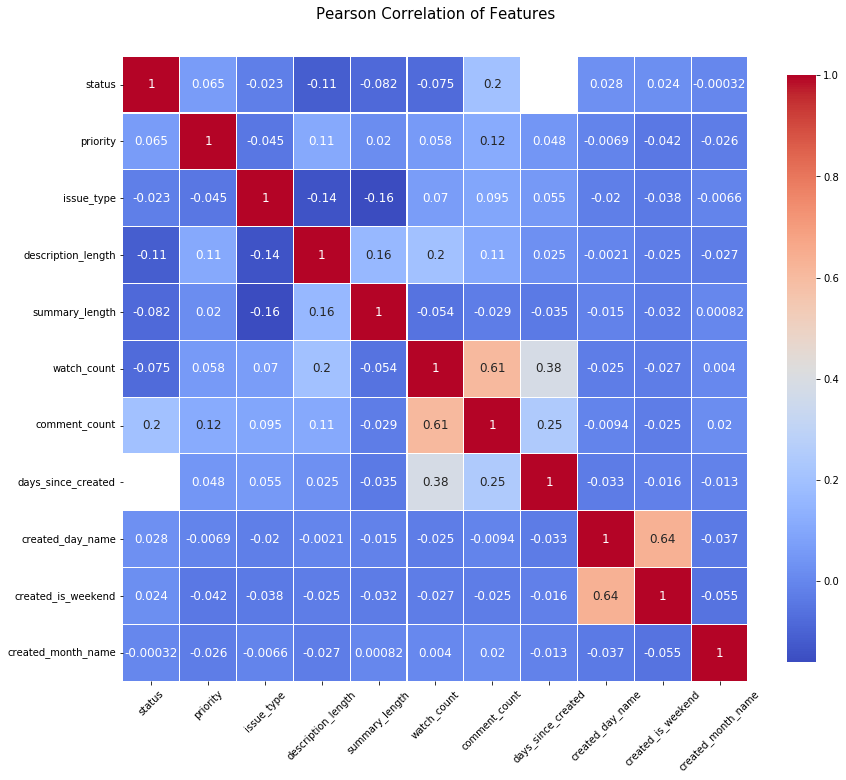

In [428]:
# Generating Correlation Heatmap to Check the Correlation Between my Data Features

def correlation_heatmap(df):
    _, ax = plt.subplots(figsize=(14, 12))
    colormap = "coolwarm"
    
    _ = sns.heatmap(
        df.corr(),
        cmap=colormap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        linewidths=0.1,
        vmax=1.0,
        linecolor='white',
        annot_kws={'fontsize': 12}
    )
    
    # Rotate x-labels with 45 degrees
    plt.xticks(rotation=45)
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(encoded_df_issues)


In [429]:
# Checking Outliers in the "days_since_created" Column

# Create an interactive boxplot using Plotly Express
fig = px.box(df_issues, y='days_since_created', title='Days since created Boxplot')

# Show the plot
fig.show()


In [430]:

# Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
df_filtered = encoded_df_issues[encoded_df_issues['status'] == 4].dropna(subset=['days_since_created']).copy()

# Create a new column 'category' to classify the issues based on 'days_since_created'
df_filtered['category'] = ['Above 114' if x > 114 else 'Below 114' for x in df_filtered['days_since_created']]

# Calculate the counts and percentages
counts = df_filtered['category'].value_counts()
percentages = df_filtered['category'].value_counts(normalize=True)*100

# Create DataFrame for plot
df_plot = pd.DataFrame({'category': counts.index, 'counts': counts.values, 'percentage': percentages.values.round(2)})

# Create the bar chart
fig = px.bar(df_plot, x='category', y='counts', hover_data=['percentage'])

# Set title name
fig.update_xaxes(title_text='Days since created category')
fig.update_layout(title='Distribution of Resolved Issues Based on Days Since Creation')

# Show the plot
fig.show()


### Outliers removal (replaced with NaNs) function exists in outliers_removal.py file
#### It is used inside the preprocessing function. It takes the encoded data and replaces outlier values with NaNs (will be removed in the prediction function)

In [431]:
# encoded_df_issues.to_csv('encoded_df_issues before removing outliers.csv', index=False)

In [432]:
# Remove outliers (remove days_since_created values that are above the upper fence/bound )

multiplier = 1.5

# Calculate the IQR of the column
IQR = encoded_df_issues['days_since_created'].quantile(0.75) - encoded_df_issues['days_since_created'].quantile(0.25)

# Define the upper and lower bounds for outliers
lower_bound = encoded_df_issues['days_since_created'].quantile(0.25) - multiplier * IQR
upper_bound = encoded_df_issues['days_since_created'].quantile(0.75) + multiplier * IQR

# Create a copy of df
no_outliers_encoded_df_issues = encoded_df_issues.copy()

# Replace outliers in df_copy with NaN
no_outliers_encoded_df_issues.loc[(no_outliers_encoded_df_issues['days_since_created'] < lower_bound) | (no_outliers_encoded_df_issues['days_since_created'] > upper_bound), 'days_since_created'] = np.nan


In [433]:
# # Remove outliers (remove days_since_created values that are above the upper fence/bound )

# multiplier = 1.5

# # Calculate the IQR of the column
# IQR = encoded_df_issues['description_length'].quantile(0.75) - encoded_df_issues['description_length'].quantile(0.25)

# # Define the upper and lower bounds for outliers
# lower_bound = encoded_df_issues['description_length'].quantile(0.25) - multiplier * IQR
# upper_bound = encoded_df_issues['description_length'].quantile(0.75) + multiplier * IQR

# # Create a copy of df
# no_outliers_encoded_df_issues = encoded_df_issues.copy()

# # Replace outliers in df_copy with NaN
# no_outliers_encoded_df_issues.loc[(no_outliers_encoded_df_issues['description_length'] < lower_bound) | (no_outliers_encoded_df_issues['description_length'] > upper_bound), 'description_length'] = np.nan


In [434]:
# no_outliers_encoded_df_issues.to_csv('no_outliers_encoded_df_issues df after removing outliers.csv', index=False)

In [435]:
# Checking Outliers in the "days_since_created" Column

# Create an interactive boxplot using Plotly Express
fig = px.box(no_outliers_encoded_df_issues, y='days_since_created', title='Days since created Boxplot')

# Show the plot
fig.show()


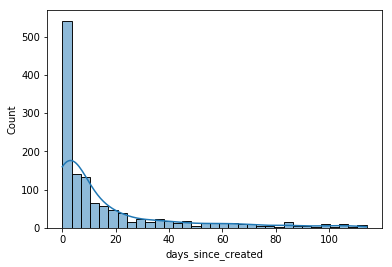

In [436]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram using seaborn
sns.histplot(data=no_outliers_encoded_df_issues, x='days_since_created', kde=True)

# Show the plot
plt.show()


In [437]:
import plotly.express as px

fig = px.histogram(no_outliers_encoded_df_issues, x="days_since_created", nbins=50, title='Distribution of days_since_created')
fig.show()


In [438]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Histogram(x=no_outliers_encoded_df_issues['days_since_created'],
                                   nbinsx=20,
                                   marker=dict(
                                       color='lightblue',
                                       line=dict(width=1, color='white')
                                   )
                     )])

fig.update_layout(
    title_text='Distribution of days_since_created',
    xaxis_title="Days Since Created",
    yaxis_title="Frequency",
)
fig.show()


# Feature Importance

In [439]:
# Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# Splitting into features and target
X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate', 'updated'], axis=1)
y = df_train['days_since_created']

# Handling NaNs in X and y
X = X.fillna(X.mean())

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Initialize the RandomForestRegressor
regressor = RandomForestRegressor()

# Fit the regressor
regressor.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [440]:
# Print the feature importances of the RandomForestRegressor.
print(regressor.feature_importances_)

[0.         0.04970102 0.04871527 0.21256218 0.1688697  0.10562007
 0.21818402 0.07804968 0.00782969 0.11046837]


In [441]:
# Create and print a sorted DataFrame of feature importances from the RandomForestRegressor model.
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                    importance
comment_count         0.218184
description_length    0.212562
summary_length        0.168870
created_month_name    0.110468
watch_count           0.105620
created_day_name      0.078050
priority              0.049701
issue_type            0.048715
created_is_weekend    0.007830
status                0.000000


In [442]:
# Plot the feature importances from the RandomForestRegressor model

feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

fig = px.bar(feature_importances, y='importance', title='Feature Importance')
fig.show()


# Modeling and Evaluation

## Model Training

## 1 - Linear Regression

In [443]:
# Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# Splitting into features and target
X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate','updated'], axis=1)
y = df_train['days_since_created']

# Handling NaNs in X and y
X = X.fillna(X.mean())

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Fitting Linear Regression to the Training set
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = linear_regressor.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)


Mean Squared Error: 474.9018104893435
Root Mean Squared Error: 21.79224197941422


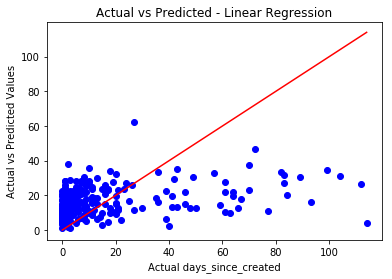

In [444]:

# Visualising the results
plt.scatter(y_test, y_pred, color = 'blue')
plt.title('Actual vs Predicted - Linear Regression')
plt.xlabel('Actual days_since_created')
plt.ylabel('Actual vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # a red line for perfect prediction
plt.show()



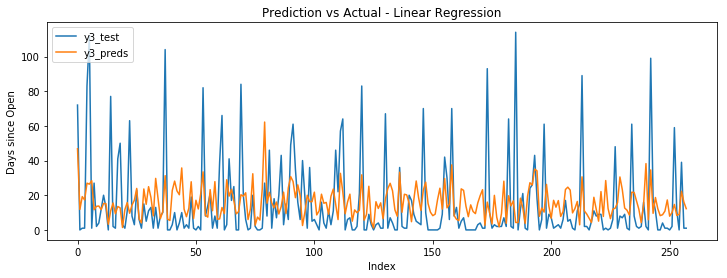

In [445]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="y3_test")
plt.plot(y_pred, label="y3_preds")
plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Days since Open')
plt.title('Prediction vs Actual - Linear Regression')
plt.show()


## 2- Random Forest Regressor

In [446]:
# Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# Splitting into features and target
X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate', 'updated'], axis=1)
y = df_train['days_since_created']

# Handling NaNs in X and y
X = X.fillna(X.mean())


# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting Random Forest Regression
regressor = RandomForestRegressor(n_estimators=800, max_depth=30, bootstrap = True, random_state=42)

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calculating Root Mean Squared Error
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)


Mean Squared Error: 606.2894963783915
Root Mean Squared Error: 24.622946541354295


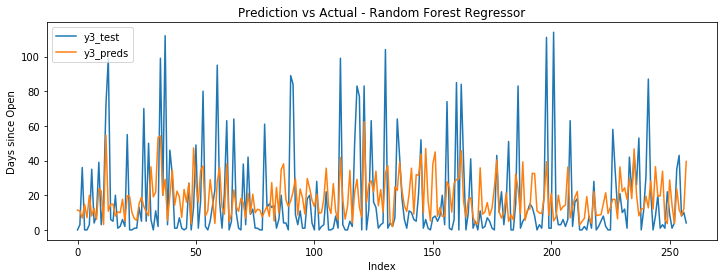

In [447]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="y3_test")
plt.plot(y_pred, label="y3_preds")
plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Days since Open')
plt.title('Prediction vs Actual - Random Forest Regressor')
plt.show()


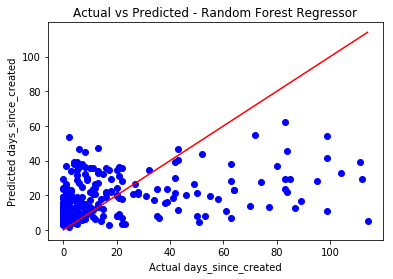

In [448]:

# Visualising the results
plt.scatter(y_test, y_pred, color = 'blue')
plt.title('Actual vs Predicted - Random Forest Regressor')
plt.xlabel('Actual days_since_created')
plt.ylabel('Predicted days_since_created')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # a red line for perfect prediction
plt.show()


## 3- XGBoost Regressor 

In [449]:
# Filter out the specific warning message
import warnings
warnings.filterwarnings('ignore')

# Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# Splitting into features and target
X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate', 'updated'], axis=1)
y = df_train['days_since_created']

# Handling NaNs in X and y
X = X.fillna(X.mean())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBRegressor()

# Fit the model to the training data
xg_reg.fit(X_train, y_train)

# Predict on the test data
y_pred = xg_reg.predict(X_test)


print('')
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calculating Root Mean Squared Error
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)


[09:58:12] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Mean Squared Error: 582.0959804993034
Root Mean Squared Error: 24.126665341470286


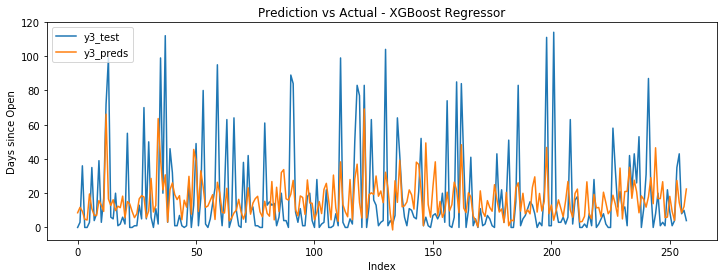

In [450]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="y3_test")
plt.plot(y_pred, label="y3_preds")
plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Days since Open')
plt.title('Prediction vs Actual - XGBoost Regressor')
plt.show()


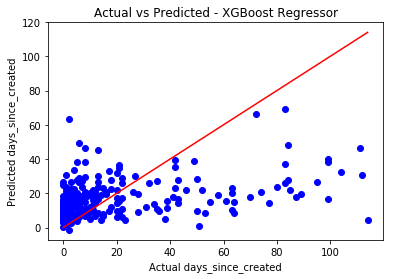

In [451]:

# Visualising the results
plt.scatter(y_test, y_pred, color = 'blue')
plt.title('Actual vs Predicted - XGBoost Regressor')
plt.xlabel('Actual days_since_created')
plt.ylabel('Predicted days_since_created')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # a red line for perfect prediction
plt.show()


# Hyperparameters Tuning

In [452]:
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import GridSearchCV

# # Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
# df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# # Splitting into features and target
# X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate','updated'], axis=1)
# y = df_train['days_since_created']

# # Handling NaNs in X and y
# X = X.fillna(X.mean())

# # Splitting the dataset into the Training set and Test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


# # Define the model
# ridge = Ridge()

# # Define the grid of hyperparameters to search
# param_grid = {
#     'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
#     'normalize': [True, False]
# }

# # Setup the grid search
# grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_parameters = grid_search.best_params_

# # Fit the model with the best parameters
# ridge_best = Ridge(**best_parameters)
# ridge_best.fit(X_train, y_train)

# # Make predictions with the best model
# y_pred_best = ridge_best.predict(X_test)

# # Evaluate the best model
# mse_best = mean_squared_error(y_test, y_pred_best)
# rmse_best = np.sqrt(mse_best)
# print('Best Model Mean Squared Error:', mse_best)
# print('Best Model Root Mean Squared Error:', rmse_best)

## Random Forest Regressor

In [453]:
# # Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
# df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# # Splitting into features and target
# X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate', 'updated'], axis=1)
# y = df_train['days_since_created']

# # Handling NaNs in X and y
# X = X.fillna(X.mean())


# # Splitting the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Instantiate the model
# rf = RandomForestRegressor()

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {
#     'n_estimators': n_estimators,
#     'max_features': max_features,
#     'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf,
#     'bootstrap': bootstrap
# }

# # Instantiate the randomized search model
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# # Fit the random search model to the data
# rf_random.fit(X_train, y_train)

# # Printing the best parameters
# print(rf_random.best_params_)

# print('')


# # # Calculate percentage of remaining iterations
# # n_total_iterations = rf_random.n_iter
# # n_completed_iterations = len(rf_random.cv_results_['mean_test_score'])
# # percentage_remaining = (n_total_iterations - n_completed_iterations) / n_total_iterations * 100
# # print(f"Percentage of remaining iterations: {percentage_remaining:.2f}%")


In [454]:
## Output:
# {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}


# After tuning the parameters

## Random Forest Regression

In [455]:
# Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# Splitting into features and target
X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate', 'updated'], axis=1)
y = df_train['days_since_created']

# Handling NaNs in X and y
X = X.fillna(X.mean())


# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Instantiate the model with the specified parameters
regressor = RandomForestRegressor(n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features='sqrt',
                                  max_depth=60, bootstrap=True)

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Calculating Root Mean Squared Error
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)



Mean Squared Error: 587.5145834174558
Root Mean Squared Error: 24.238700118146927


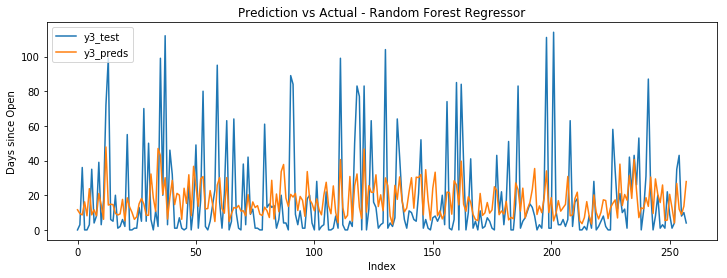

In [456]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.values, label="y3_test")
plt.plot(y_pred, label="y3_preds")
plt.legend(loc='upper left')
plt.xlabel('Index')
plt.ylabel('Days since Open')
plt.title('Prediction vs Actual - Random Forest Regressor')
plt.show()

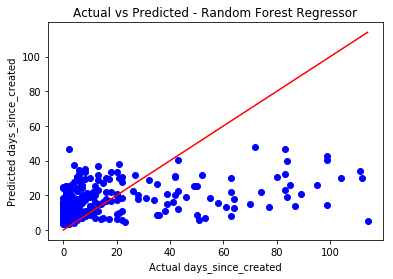

In [457]:
# Visualising the results
plt.scatter(y_test, y_pred, color = 'blue')
plt.title('Actual vs Predicted - Random Forest Regressor')
plt.xlabel('Actual days_since_created')
plt.ylabel('Predicted days_since_created')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # a red line for perfect prediction
plt.show()

In [458]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV

# # Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
# df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# # Splitting into features and target
# X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate','updated'], axis=1)
# y = df_train['days_since_created']

# # Handling NaNs in X and y
# X = X.fillna(X.mean())

# # Splitting the dataset into the Training set and Test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# # Define the model
# xgb = XGBRegressor()

# # Define the grid of hyperparameters to search
# param_grid = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [2, 4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'subsample': [0.5, 0.7, 1.0],
#     'colsample_bytree': [0.4, 0.6, 0.8, 1.0]
# }

# # Setup the grid search
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_parameters = grid_search.best_params_

# # Fit the model with the best parameters
# xgb_best = XGBRegressor(**best_parameters)
# xgb_best.fit(X_train, y_train)

# # Make predictions with the best model
# y_pred_best = xgb_best.predict(X_test)

# # Evaluate the best model
# mse_best = mean_squared_error(y_test, y_pred_best)
# rmse_best = np.sqrt(mse_best)
# print('Best Model Mean Squared Error:', mse_best)
# print('Best Model Root Mean Squared Error:', rmse_best)


# Save the selected trained model in this assignment

## Linear Regression

In [459]:

# # Filtering the rows with status = 4 (Resolved) and no missing values for days_since_created
# df_train = no_outliers_encoded_df_issues[no_outliers_encoded_df_issues['status'] == 4].dropna(subset=['days_since_created'])

# # Splitting into features and target
# X = df_train.drop(['key', 'days_since_created', 'created', 'resolutiondate', 'created_is_weekend', 'status', 'updated'], axis=1)
# y = df_train['days_since_created']

# # Handling NaNs in X and y
# X = X.fillna(X.mean())

# # Fitting Linear Regression to the Training set
# linear_regressor = LinearRegression()
# linear_regressor.fit(X, y)


# # Save the trained model to an h5 file
# with h5py.File('../linear_regression_model.h5', 'w') as file:
#     file.create_dataset('coef_', data=linear_regressor.coef_)
#     file.create_dataset('intercept_', data=linear_regressor.intercept_)



# Model Prediction

### Prediction function exists in predict.py file
#### The function takes the raw data. It contains the preprocessing function.

In [460]:
# Load the h5 file
with h5py.File('../linear_regression_model.h5', 'r') as file:
    coef_ = file['coef_'][()]  # Retrieve the coefficients
    intercept_ = file['intercept_'][()]  # Retrieve the intercept


In [461]:
df_avro_issues.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,In Progress,Major,2018-04-21T15:44:36.749+0000,Improvement,rlenferink,2018-04-17T21:53:05.730+0000,NaN,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599
1,In Progress,Minor,2018-04-21T15:42:40.935+0000,Improvement,rlenferink,2018-04-17T21:47:11.197+0000,NaN,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939
2,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06T13:45:28.721+0000,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288
3,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05T13:21:01.183+0000,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04T16:39:43.364+0000,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785


In [462]:
# Load the new preprocessed dataset
preprocessed_df = preprocess_data(df_avro_issues).drop(['days_since_created', 'status'], axis=1)
# Handling NaNs (here some NaNs may exist in the description length feature)
preprocessed_df = preprocessed_df.fillna(preprocessed_df.mean())

In [463]:
preprocessed_df.head()

,priority,issue_type,description_length,summary_length,watch_count,comment_count,created_day_name,created_month_name
0,3,1,233.0,43,1,1,2,4
1,2,1,528.0,68,2,1,2,4
2,3,1,1062.0,75,1,0,5,4
3,3,0,272.0,64,1,1,4,4
4,3,0,674.0,53,1,0,3,4


In [464]:
# Create an instance of the Linear Regression model using the retrieved coefficients and intercept
linear_regressor = LinearRegression()
linear_regressor.coef_ = coef_
linear_regressor.intercept_ = intercept_

In [465]:
# Make predictions on the new dataset
predictions = linear_regressor.predict(preprocessed_df)

In [466]:
# copy the raw dataset and add the predicted days_since_created for the unresolved issues
final_resolution_date_df = df_avro_issues.copy()
final_resolution_date_df['days_since_created'] = predictions

In [467]:
final_resolution_date_df.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status,days_since_created
0,In Progress,Major,2018-04-21T15:44:36.749+0000,Improvement,rlenferink,2018-04-17T21:53:05.730+0000,NaN,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599,8.833945
1,In Progress,Minor,2018-04-21T15:42:40.935+0000,Improvement,rlenferink,2018-04-17T21:47:11.197+0000,NaN,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939,11.195960
2,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06T13:45:28.721+0000,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288,10.740907
3,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05T13:21:01.183+0000,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536,8.820156
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04T16:39:43.364+0000,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785,7.863735


In [468]:
# Make sure 'created' is datetime and 'days_since_created' is timedelta to add them to get resolutiondate datetime
final_resolution_date_df['created'] = pd.to_datetime(final_resolution_date_df['created'])
final_resolution_date_df['days_since_created'] = pd.to_timedelta(final_resolution_date_df['days_since_created'], unit='D')


In [469]:
final_resolution_date_df.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status,days_since_created
0,In Progress,Major,2018-04-21T15:44:36.749+0000,Improvement,rlenferink,2018-04-17 21:53:05.730,NaN,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599,8 days 20:00:52.848000
1,In Progress,Minor,2018-04-21T15:42:40.935+0000,Improvement,rlenferink,2018-04-17 21:47:11.197,NaN,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939,11 days 04:42:10.944000
2,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06 13:45:28.721,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288,10 days 17:46:54.364800
3,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05 13:21:01.183,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536,8 days 19:41:01.478400
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04 16:39:43.364,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785,7 days 20:43:46.704000


In [470]:
final_resolution_date_df['days_since_created'].dtype

dtype('<m8[ns]')

In [471]:
# Convert 'created' column to string
final_resolution_date_df['created'] = final_resolution_date_df['created'].astype(str)

# Split the string on the dot and take the first part
final_resolution_date_df['created'] = final_resolution_date_df['created'].str.split('.').str[0]

# Convert the string back to datetime format
final_resolution_date_df['created'] = pd.to_datetime(final_resolution_date_df['created'])

In [472]:
# Convert 'days_since_created' to timedelta format
final_resolution_date_df['days_since_created'] = pd.to_timedelta(
    final_resolution_date_df['days_since_created']
    .dt
    .total_seconds()
    .astype(int)
    .astype('timedelta64[s]')
)

In [473]:
final_resolution_date_df.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status,days_since_created
0,In Progress,Major,2018-04-21T15:44:36.749+0000,Improvement,rlenferink,2018-04-17 21:53:05,NaN,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599,8 days 20:00:52
1,In Progress,Minor,2018-04-21T15:42:40.935+0000,Improvement,rlenferink,2018-04-17 21:47:11,NaN,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939,11 days 04:42:10
2,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06 13:45:28,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288,10 days 17:46:54
3,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05 13:21:01,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536,8 days 19:41:01
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04 16:39:43,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785,7 days 20:43:46


In [474]:
final_resolution_date_df['days_since_created'].dtype

dtype('<m8[ns]')

In [475]:
final_resolution_date_df['created'].dtype

dtype('<M8[ns]')

In [476]:
# Convert 'resolutiondate' column to datetime
final_resolution_date_df['resolutiondate'] = pd.to_datetime(final_resolution_date_df['resolutiondate'])

# Check if 'resolutiondate' is NaN
mask = pd.isna(final_resolution_date_df['resolutiondate'])

# Add the timedelta to 'created' and assign the result to 'resolutiondate' where 'resolutiondate' is NaN
final_resolution_date_df.loc[mask, 'resolutiondate'] = final_resolution_date_df['created'] + final_resolution_date_df['days_since_created']

In [477]:
cols = ['created', 'days_since_created', 'resolutiondate'] + [col for col in final_resolution_date_df.columns if col not in ['created', 'days_since_created', 'resolutiondate']]
final_resolution_date_df = final_resolution_date_df.reindex(columns=cols)


In [478]:
final_resolution_date_df.head()

,created,days_since_created,resolutiondate,status,priority,updated,issue_type,reporter,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,2018-04-17 21:53:05,8 days 20:00:52,2018-04-26 17:53:57.000,In Progress,Major,2018-04-21T15:44:36.749+0000,Improvement,rlenferink,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599
1,2018-04-17 21:47:11,11 days 04:42:10,2018-04-29 02:29:21.000,In Progress,Minor,2018-04-21T15:42:40.935+0000,Improvement,rlenferink,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939
2,2018-04-06 13:45:28,10 days 17:46:54,2018-04-24 06:34:58.762,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288
3,2018-04-05 13:21:01,8 days 19:41:01,2018-04-24 06:34:37.339,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536
4,2018-04-04 16:39:43,7 days 20:43:46,2018-04-24 06:34:15.829,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785


In [479]:
# Define the list of columns that contain datetime data
datetime_columns = ['created', 'updated', 'resolutiondate']

# Convert the datetime columns to datetime format and format them as strings
final_resolution_date_df[datetime_columns] = final_resolution_date_df[datetime_columns].apply(
    lambda x: x.apply(lambda y: pd.to_datetime(y).strftime('%Y-%m-%d %H:%M:%S')), axis=1
)

In [480]:
final_resolution_date_df.head()

,created,days_since_created,resolutiondate,status,priority,updated,issue_type,reporter,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,2018-04-17 21:53:05,8 days 20:00:52,2018-04-26 17:53:57,In Progress,Major,2018-04-21 15:44:36,Improvement,rlenferink,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599
1,2018-04-17 21:47:11,11 days 04:42:10,2018-04-29 02:29:21,In Progress,Minor,2018-04-21 15:42:40,Improvement,rlenferink,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939
2,2018-04-06 13:45:28,10 days 17:46:54,2018-04-24 06:34:58,Resolved,Major,2018-04-24 06:34:58,Improvement,jmukesh,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288
3,2018-04-05 13:21:01,8 days 19:41:01,2018-04-24 06:34:37,Resolved,Major,2018-04-24 06:34:37,Bug,jmukesh,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536
4,2018-04-04 16:39:43,7 days 20:43:46,2018-04-24 06:34:15,Resolved,Major,2018-04-24 06:34:15,Bug,jmukesh,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785


In [481]:
df_avro_issues.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,In Progress,Major,2018-04-21T15:44:36.749+0000,Improvement,rlenferink,2018-04-17T21:53:05.730+0000,NaN,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599
1,In Progress,Minor,2018-04-21T15:42:40.935+0000,Improvement,rlenferink,2018-04-17T21:47:11.197+0000,NaN,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939
2,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06T13:45:28.721+0000,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288
3,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05T13:21:01.183+0000,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04T16:39:43.364+0000,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785


In [482]:
final_resolution_date_df.head()

,created,days_since_created,resolutiondate,status,priority,updated,issue_type,reporter,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,2018-04-17 21:53:05,8 days 20:00:52,2018-04-26 17:53:57,In Progress,Major,2018-04-21 15:44:36,Improvement,rlenferink,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599
1,2018-04-17 21:47:11,11 days 04:42:10,2018-04-29 02:29:21,In Progress,Minor,2018-04-21 15:42:40,Improvement,rlenferink,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939
2,2018-04-06 13:45:28,10 days 17:46:54,2018-04-24 06:34:58,Resolved,Major,2018-04-24 06:34:58,Improvement,jmukesh,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288
3,2018-04-05 13:21:01,8 days 19:41:01,2018-04-24 06:34:37,Resolved,Major,2018-04-24 06:34:37,Bug,jmukesh,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536
4,2018-04-04 16:39:43,7 days 20:43:46,2018-04-24 06:34:15,Resolved,Major,2018-04-24 06:34:15,Bug,jmukesh,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785


In [483]:
## Save the final dataframe to be used in in the unit test
# final_resolution_date_df.to_csv('../data/for testing final_resolution_date_df after predicting.csv', index = False)

In [484]:
final_resolution_date_df.dtypes

created                            object
days_since_created        timedelta64[ns]
resolutiondate                     object
status                             object
priority                           object
updated                            object
issue_type                         object
reporter                           object
vote_count                          int64
project                            object
assignee                           object
comment_count                       int64
key                                object
description_length                float64
summary_length                      int64
watch_count                         int64
resolution                         object
days_in_current_status            float64
dtype: object

## Test it

In [485]:
# Get the resolutiondate for a specific issue key
resolution_date = final_resolution_date_df.loc[final_resolution_date_df['key'] == 'AVRO-2171', 'resolutiondate'].values[0]
resolution_date

'2018-04-26 17:53:57'

In [486]:
# Get the unresolved data after predicting the issues resolution dates
unresolved_issues = final_resolution_date_df[~final_resolution_date_df['status'].isin(['Resolved', 'Closed'])]
unresolved_issues

,created,days_since_created,resolutiondate,status,priority,updated,issue_type,reporter,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,2018-04-17 21:53:05,8 days 20:00:52,2018-04-26 17:53:57,In Progress,Major,2018-04-21 15:44:36,Improvement,rlenferink,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599
1,2018-04-17 21:47:11,11 days 04:42:10,2018-04-29 02:29:21,In Progress,Minor,2018-04-21 15:42:40,Improvement,rlenferink,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939
6,2018-04-01 13:08:48,8 days 04:25:49,2018-04-09 17:34:37,Patch Available,Minor,2018-04-01 13:19:20,Improvement,thiru_mg,0,AVRO,NaN,1,AVRO-2165,307.0,57,1,NaN,24.744480
7,2018-03-23 13:13:13,22 days 01:08:33,2018-04-14 14:21:46,Open,Major,2018-03-23 17:16:08,Improvement,BigAndy,0,AVRO,NaN,6,AVRO-2164,1101.0,32,4,NaN,33.748731
8,2018-03-22 18:10:17,10 days 00:01:44,2018-04-01 18:12:01,Open,Major,2018-03-23 08:14:38,Task,busbey,0,AVRO,sacharya,0,AVRO-2163,83.0,13,1,NaN,34.542435
9,2018-03-22 07:38:21,22 days 20:01:38,2018-04-14 03:39:59,Open,Major,2018-03-30 09:30:51,Improvement,scott_carey,0,AVRO,NaN,11,AVRO-2162,430.0,45,3,NaN,34.981280
10,2018-03-17 14:57:46,8 days 21:38:41,2018-03-26 12:36:27,Patch Available,Major,2018-03-17 15:14:56,Improvement,blachniet,0,AVRO,NaN,1,AVRO-2161,614.0,34,1,NaN,39.664205
11,2018-03-15 21:24:19,11 days 09:05:57,2018-03-27 06:30:16,Open,Critical,2018-04-19 23:41:09,Bug,Prevost,0,AVRO,NaN,0,AVRO-2160,2035.0,61,1,NaN,41.407691
12,2018-03-15 03:11:17,19 days 09:48:35,2018-04-03 12:59:52,Open,Major,2018-03-15 03:11:17,New Feature,howellbridger,1,AVRO,NaN,0,AVRO-2159,6157.0,60,2,NaN,42.166738
13,2018-03-11 01:15:22,7 days 08:56:48,2018-03-18 10:12:10,Open,Minor,2018-03-11 01:15:22,New Feature,blachniet,0,AVRO,NaN,0,AVRO-2158,837.0,26,1,NaN,46.247232
